A machine learning approach for predicting familial and sporadic disease cases based on clinical *symptoms*

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score
)


In [3]:
from google.colab import files
uploaded = files.upload()


Saving dataset-uci.xlsx to dataset-uci.xlsx


In [6]:
filename = list(uploaded.keys())[0]
filename
import pandas as pd

df = pd.read_excel(filename)
df.head()

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (296, 20)
Columns: ['Unnamed: 0', 'Case Type', 'Tumour Case', 'Age of Mother', 'Age of Father', 'Age at First Diagnosis', 'Café au lait (CLS)', 'Axillary Freckles', 'Inguinal Freckles', 'Lisch Nodules', 'Dermal Neurofibromins', 'Plexiform Neurofibromins', 'Optic Glioma', 'Skeletal Dysplasia', 'Learning Disability', 'Hypertension', 'Astrocytoma', 'Hamartoma', 'Scoliosis', 'Other Symptoms']


,Unnamed: 0,Case Type,Tumour Case,Age of Mother,Age of Father,Age at First Diagnosis,Café au lait (CLS),Axillary Freckles,Inguinal Freckles,Lisch Nodules,Dermal Neurofibromins,Plexiform Neurofibromins,Optic Glioma,Skeletal Dysplasia,Learning Disability,Hypertension,Astrocytoma,Hamartoma,Scoliosis,Other Symptoms
0,1,0,1,30.0,31.0,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2,0,1,22.0,29.0,7.0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
2,3,1,1,28.0,26.0,9.0,1,1,0,0,1,0,0,1,0,0,0,0,0,1
3,4,0,1,30.0,34.0,9.0,1,1,0,1,0,1,0,0,0,0,0,0,0,1
4,5,0,1,27.0,34.0,1.0,1,1,1,0,0,0,1,0,0,0,0,0,0,1


In [7]:
df.isna().sum().sort_values(ascending=False)


,0
Age of Mother,35
Age of Father,34
Age at First Diagnosis,4
Unnamed: 0,0
Tumour Case,0
Case Type,0
Café au lait (CLS),0
Axillary Freckles,0
Inguinal Freckles,0
Lisch Nodules,0


In [8]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])


In [9]:
target_col = "Case Type"
assert target_col in df.columns, f"Target column '{target_col}' not found!"


In [10]:
y = df[target_col]
X = df.drop(columns=[target_col])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (296, 18)
y shape: (296,)


In [11]:
y.value_counts(dropna=False), y.value_counts(normalize=True, dropna=False)


(Case Type
 0    161
 1    135
 Name: count, dtype: int64,
 Case Type
 0    0.543919
 1    0.456081
 Name: proportion, dtype: float64)

In [12]:
num_cols = ["Age of Mother", "Age of Father", "Age at First Diagnosis"]
num_cols = [c for c in num_cols if c in X.columns]  # keep only those that exist
other_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Other cols count:", len(other_cols))


Numeric cols: ['Age of Mother', 'Age of Father', 'Age at First Diagnosis']
Other cols count: 15


processing

In [13]:
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

other_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("other", other_pipe, other_cols)
    ],
    remainder="drop"
)


baseline

In [14]:
model = LogisticRegression(max_iter=2000, class_weight="balanced")


In [15]:
pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])


train & test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (236, 18) Test: (60, 18)


In [17]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age of Mother',
                                                   'Age of Father',
                                                   'Age at First Diagnosis']),
                                                 ('other',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Tumour Case',
                                                   'Café au lait (CLS)',
                                                   'Axillary Freckles',
                                                   'Inguinal Freckles',
                                                   'Lisch Nodules',
                                                   'Dermal Neurofibromins',
                                                   'Plexiform Neurofibromins',
                                                   'Optic Glioma',
                                                   'Skeletal Dysplasia',
                                                   'Learning Disability',
                                                   'Hypertension',
                                                   'Astrocytoma', 'Hamartoma',
                                                   'Scoliosis',
                                                   'Other Symptoms'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [18]:
y_pred = pipe.predict(X_test)

# For ROC-AUC we need probabilities for the positive class
y_proba = pipe.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


ROC-AUC: 0.48597081930415265

Confusion Matrix:
 [[18 15]
 [20  7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.55      0.51        33
           1       0.32      0.26      0.29        27

    accuracy                           0.42        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.40      0.42      0.41        60



ROC–AUC ≈ 0.49

AUC = 0.5 → random

Model cannot distinguish familial vs sporadic

This means:

Either features have weak signal as currently encoded

Or preprocessing is sub-optimal

Or the relationship is non-linear (Logistic Regression can’t see it)

cross validation

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring=["roc_auc", "f1", "precision", "recall"],
    return_train_score=False
)

{metric: scores[metric].mean() for metric in scores if metric.startswith("test_")}


{'test_roc_auc': np.float64(0.5042508417508417),
 'test_f1': np.float64(0.4641722642837719),
 'test_precision': np.float64(0.46625132275132275),
 'test_recall': np.float64(0.4666666666666666)}

In [21]:
df["Case Type"].value_counts()


,count
Case Type,
0,161
1,135


In [22]:
df["Case Type"] = df["Case Type"].map({
    "Sporadic": 0,
    "Familial": 1
})


In [23]:
X.describe().T
#basic noise reduction

,count,mean,std,min,25%,50%,75%,max
Tumour Case,296.0,0.277027,0.448288,0.0,0.00,0.0,1.0,1.0
Age of Mother,261.0,27.176245,5.801158,16.0,23.00,27.0,31.0,45.0
Age of Father,262.0,31.881679,6.702013,19.0,27.00,31.0,35.0,62.0
Age at First Diagnosis,292.0,11.878425,10.731643,0.5,4.75,9.0,15.0,61.0
Café au lait (CLS),296.0,0.932432,0.251427,0.0,1.00,1.0,1.0,1.0
Axillary Freckles,296.0,0.533784,0.499702,0.0,0.00,1.0,1.0,1.0
Inguinal Freckles,296.0,0.270270,0.444851,0.0,0.00,0.0,1.0,1.0
Lisch Nodules,296.0,0.280405,0.449958,0.0,0.00,0.0,1.0,1.0
Dermal Neurofibromins,296.0,0.277027,0.448288,0.0,0.00,0.0,1.0,1.0
Plexiform Neurofibromins,296.0,0.138514,0.346023,0.0,0.00,0.0,0.0,1.0


**random forest**

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42
)

pipe_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf)
])

pipe_rf.fit(X_train, y_train)

y_pred = pipe_rf.predict(X_test)
y_proba = pipe_rf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.45679012345679004
[[19 14]
 [16 11]]
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        33
           1       0.44      0.41      0.42        27

    accuracy                           0.50        60
   macro avg       0.49      0.49      0.49        60
weighted avg       0.50      0.50      0.50        60



Gradient Boosting

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)

pipe_gb = Pipeline(steps=[
    ("prep", preprocess),
    ("model", gb)
])

pipe_gb.fit(X_train, y_train)

y_pred = pipe_gb.predict(X_test)
y_proba = pipe_gb.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.5454545454545454
[[23 10]
 [14 13]]
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        33
           1       0.57      0.48      0.52        27

    accuracy                           0.60        60
   macro avg       0.59      0.59      0.59        60
weighted avg       0.60      0.60      0.60        60



Support Vector Machine

In [26]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    class_weight="balanced",
    random_state=42
)

pipe_svm = Pipeline(steps=[
    ("prep", preprocess),
    ("model", svm)
])

pipe_svm.fit(X_train, y_train)

y_pred = pipe_svm.predict(X_test)
y_proba = pipe_svm.predict_proba(X_test)[:, 1]

print("SVM ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


SVM ROC-AUC: 0.6245791245791246
[[10 23]
 [19  8]]
              precision    recall  f1-score   support

           0       0.34      0.30      0.32        33
           1       0.26      0.30      0.28        27

    accuracy                           0.30        60
   macro avg       0.30      0.30      0.30        60
weighted avg       0.31      0.30      0.30        60



Neural Network (MLP)

In [27]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    max_iter=1000,
    random_state=42
)

pipe_mlp = Pipeline(steps=[
    ("prep", preprocess),
    ("model", mlp)
])

pipe_mlp.fit(X_train, y_train)

y_pred = pipe_mlp.predict(X_test)
y_proba = pipe_mlp.predict_proba(X_test)[:, 1]

print("MLP ROC-AUC:", roc_auc_score(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


MLP ROC-AUC: 0.5881032547699214
[[21 12]
 [10 17]]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66        33
           1       0.59      0.63      0.61        27

    accuracy                           0.63        60
   macro avg       0.63      0.63      0.63        60
weighted avg       0.64      0.63      0.63        60



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


over fitting

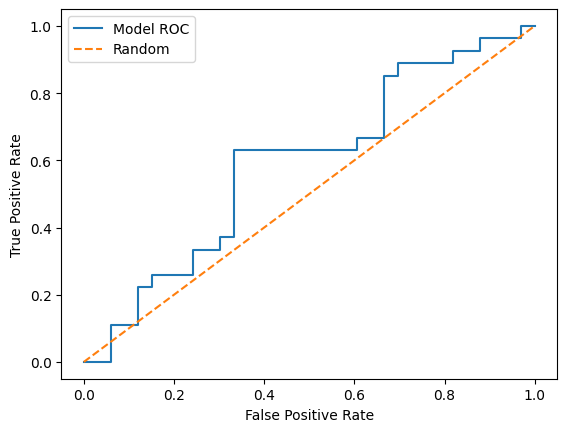

In [28]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label="Model ROC")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [20]:
# Get feature names after preprocessing
feature_names = []
if len(num_cols) > 0:
    feature_names += num_cols
feature_names += other_cols

coefs = pipe.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

coef_df.head(15)


,feature,coef,abs_coef
4,Café au lait (CLS),-0.558106,0.558106
7,Lisch Nodules,-0.534975,0.534975
13,Hypertension,-0.481058,0.481058
11,Skeletal Dysplasia,0.437742,0.437742
5,Axillary Freckles,0.392342,0.392342
17,Other Symptoms,-0.377789,0.377789
9,Plexiform Neurofibromins,0.344325,0.344325
3,Tumour Case,0.334065,0.334065
10,Optic Glioma,0.261219,0.261219
15,Hamartoma,0.234420,0.234420
